In [9]:
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

def perform_cca(train_expression, train_methylation, 
                method='PLSRegression'):
    if method == 'PLSRegression':
        cca = PLSRegression(n_components=10)
    elif method == 'PLSCanonical':
        cca = PLSCanonical(n_components=10)
    elif method == 'CCA':
        cca = CCA(n_components=10)
    cca.fit(train_expression, train_methylation)
    return cca


def finentune(train_expression, train_methylation):
    methods = ['PLSCanonical', 'PLSRegression', 'CCA']
    res = []
    kf = KFold(n_splits=3)
    from tqdm import tqdm
    for method in methods:
        val_score_rawmax, val_score_weighted = 0, 0
        for train_index, test_index in kf.split(train_expression.values):
            train_exp, val_exp = train_expression.values[train_index], train_expression.values[test_index]
            train_met, val_met = train_methylation.values[train_index], train_methylation.values[test_index]
            cca = perform_cca(train_exp, train_met, method)
            predict_v_met = cca.predict(val_exp)
            val_score_rawmax += np.max(r2_score(val_met, predict_v_met, multioutput='raw_values'))
            val_score_weighted += r2_score(val_met, predict_v_met, multioutput='variance_weighted')
        res = [method, val_score_rawmax/3, val_score_weighted/3]
    res_df = pd.DataFrame(data=res, columns=['method', 'raw_max', 'weighted'])
    return res_df

def find_bestParam_wrap(train_expression, train_methylation, metric='weighted'):
    res_df = finentune(train_expression, train_methylation)
    best_method = res_df.loc[res_df.metric.idxmax()]
    best_cca = perform_cca(train_expression, train_methylation, 
                           method=best_method.method)
    return best_cca


def perform_cca_andpca(train_expression, train_methylation, n_expression, n_methylation, ranking=True):
    print('Performing pca+plsregression..')
    if not ranking:
        pipe_expression = Pipeline(steps=[('scaler', StandardScaler()),
                               ('pca', PCA(n_components=n_expression))])
        pipe_methylation = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('pca', PCA(n_components=n_methylation, whiten=True))])
        train_preprocessed_expression = pipe_expression.fit_transform(train_expression)
        train_preprocessed_methylation = pipe_methylation.fit_transform(train_methylation)
    else:
        from sklearn.preprocessing import QuantileTransformer
        pipe_expression = Pipeline(steps=[('scaler', StandardScaler()),
                                          ('pca', PCA(n_components=n_expression)),
                                          ('qqnorm', QuantileTransformer())])
        pipe_methylation = Pipeline(steps=[('scaler', StandardScaler()),
                                           ('pca', PCA(n_components=n_methylation, whiten=True)),
                                           ('qqnorm', QuantileTransformer())])
        train_preprocessed_expression = pipe_expression.fit_transform(train_expression)
        train_preprocessed_methylation = pipe_methylation.fit_transform(train_methylation)
    cca = PLSCanonical(n_components=10)
    cca.fit(train_preprocessed_expression, train_preprocessed_methylation)
    return pipe_expression, pipe_methylation, cca


def finetune_for_pca_number(n_expression_list, n_methylation_list, 
              train_expression, train_methylation, metric='raw_values', ranking=True):
    print('Finetuning...')
    res = []
    from tqdm import tqdm
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=3)
    for n_expression in tqdm(n_expression_list):
        for n_methylation in n_methylation_list:
            val_scores = []
            for train_index, test_index in kf.split(train_expression.values):
                train_exp, val_exp = train_expression.values[train_index], train_expression.values[test_index]
                train_met, val_met = train_methylation.values[train_index], train_methylation.values[test_index]
                pipe_exp, pipe_met, cca = perform_cca_andpca(train_exp, train_met,
                                  n_expression=n_expression, 
                                  n_methylation=n_methylation,
                                  ranking=ranking)
                predict_v_met = cca.predict(pipe_exp.transform(val_exp))
                print(predict_v_met.shape, val_met.shape)
                val_score = np.max(r2_score(pipe_met.transform(val_met), predict_v_met, multioutput=metric))
                val_scores.append(val_score)
            res.append([n_expression, n_methylation, np.mean(val_scores)])
    res_df = pd.DataFrame(data=res, columns=['n_expression', 'n_methylation', 'r_square'])
    return res_df

def find_bestPCANumber_wrap(train_expression, train_methylation,
                       n_expression_list, n_methylation_list, metric='raw_values', ranking=True):
    print("Start Finding")
    res_df = finetune_for_pca_number(n_expression_list, n_methylation_list, 
                       train_expression, train_methylation, metric=metric, ranking=ranking)
    best_param = res_df.loc[res_df.r_square.idxmax()]
    best_pipe_exp, best_pipe_met, best_cca = perform_cca_andpca(train_expression, train_methylation, 
                           n_expression=int(best_param.n_expression),
                           n_methylation=int(best_param.n_methylation),
                           ranking=ranking)
    return best_pipe_exp, best_pipe_met, best_cca

def read_pipe_cca(save_prefix, name):
    pipe_exp = pickle.load(open(f'{save_prefix}/preprocessing_for_expression_of_{name}.pkl', 'rb'))
    pipe_met = pickle.load(open(f'{save_prefix}/preprocessing_for_methylation_of_{name}.pkl', 'rb'))
    cca = pickle.load(open(f'{save_prefix}/cca_transformation_for_{name}.pkl', 'rb'))
    return pipe_exp, pipe_met, cca

In [10]:
# load cca data
data_dir = Path("./supplementary_materials/data/")
selected_exp_data = np.load(data_dir/'cca_data/public_expression_eqtms.npy')
selected_exp_rows = [item.strip() for item in 
                     open(data_dir/'cca_data/public_expression_eqtms.rows.txt', 'r').readlines()]
selected_exp_cols = [item.strip() for item in 
                     open(data_dir/'cca_data/public_expression_eqtms.cols.txt', 'r').readlines()]
selected_exp_df = pd.DataFrame(data=selected_exp_data,
                            index=selected_exp_rows,
                            columns=selected_exp_cols)
selected_met_data = np.load(data_dir/'cca_data/public_methylation_eqtms.npy')
selected_met_rows = [item.strip() for item in 
                     open(data_dir/'cca_data/public_methylation_eqtms.rows.txt', 'r').readlines()]
selected_met_cols = [item.strip().split('_')[0] for item in 
                     open(data_dir/'cca_data/public_methylation_eqtms.cols.txt').readlines()]
selected_met_df = pd.DataFrame(data=selected_met_data,
                               index=selected_met_rows,
                               columns=selected_met_cols)

# load eqtms
eqtms = pd.read_csv(data_dir/'eqtm_summary_statistics/eQTMs_metaanalysis.tsv', sep='\t')
concat_cpgs_set = set(selected_met_df.index)
concat_genes_set = set(selected_exp_df.index)
inConcat = lambda x:True if x[0] in concat_cpgs_set and x[1] in concat_genes_set else False
eqtms['inConcat'] = [inConcat(item) for item in eqtms[['SNPName', 'ProbeName']].values]
valid_eqtms = eqtms[eqtms['inConcat']]
unique_eqtms = valid_eqtms.sort_values('PValue').drop_duplicates('ProbeName').drop_duplicates('SNPName')

# load models
model_dir = "./supplementary_materials/models/cca_transformations"
pipe_negative_expression, pipe_negative_methylation, negative_cca = read_pipe_cca(model_dir, "negative_eqtms")
pipe_positive_expression, pipe_positive_methylation, positive_cca = read_pipe_cca(model_dir, "positive_eqtms")
pipe_unflipped_expression, pipe_unflipped_methylation, unflipped_cca = read_pipe_cca(model_dir, "alleqtms")
pipe_flipped_expression, pipe_flipped_methylation, flipped_cca = read_pipe_cca(model_dir, "alleqtms_flipped")

In [11]:
random_state = 9
negative_eqtms = unique_eqtms[unique_eqtms['OverallZScore']<=0]
positive_eqtms = unique_eqtms[unique_eqtms['OverallZScore']>=0]
n_expression_list, n_methylation_list = range(80, 241, 40), range(80, 241, 40)
# negative
negative_expression = selected_exp_df.loc[negative_eqtms['ProbeName']]
negative_methylation = selected_met_df.loc[negative_eqtms['SNPName']]
train_negative_expression, test_negative_expression, train_negative_methylation, test_negative_methylation = \
train_test_split(negative_expression, 
                 negative_methylation,
                 random_state=random_state)
# positive
positive_expression = selected_exp_df.loc[positive_eqtms['ProbeName']]
positive_methylation = selected_met_df.loc[positive_eqtms['SNPName']]
train_positive_expression, test_positive_expression, train_positive_methylation, test_positive_methylation = \
train_test_split(positive_expression, 
                 positive_methylation,
                 random_state=8)

# unflipped
train_unflipped_expression, test_unflipped_expression, train_unflipped_methylation, test_unflipped_methylation = \
train_test_split(selected_exp_df.loc[unique_eqtms['ProbeName']], 
                 selected_met_df.loc[unique_eqtms['SNPName']],
                 random_state=8)
# flipped
flipped_methylation = pd.concat([-1*negative_methylation, positive_methylation], axis=0)
flipped_expression = pd.concat([negative_expression, positive_expression], axis=0)
train_flipped_expression, test_flipped_expression, train_flipped_methylation, test_flipped_methylation = \
train_test_split(flipped_expression, 
                 flipped_methylation,
                 random_state=8)

# apply the trained CCA
cca_test_negative_expression, cca_test_negative_methylation = \
negative_cca.transform(pipe_negative_expression.transform(test_negative_expression),
                       pipe_negative_methylation.transform(test_negative_methylation))
cca_test_positive_expression, cca_test_positive_methylation = \
positive_cca.transform(pipe_positive_expression.transform(test_positive_expression),
                       pipe_positive_methylation.transform(test_positive_methylation))
cca_test_unflipped_expression, cca_test_unflipped_methylation = \
unflipped_cca.transform(pipe_unflipped_expression.transform(test_unflipped_expression),
                        pipe_unflipped_methylation.transform(test_unflipped_methylation))

cca_test_flipped_expression, cca_test_flipped_methylation = \
flipped_cca.transform(pipe_flipped_expression.transform(test_flipped_expression),
                        pipe_flipped_methylation.transform(test_flipped_methylation))

## for training CCA
# pipe_negative_expression, pipe_negative_methylation, negative_cca = find_bestPCANumber_wrap(train_negative_expression, 
#                                                                                         train_negative_methylation,
#                                                                                         n_expression_list, 
#                                                                                         n_methylation_list, 
#                                                                                         metric='raw_values', 
#                                                                                         ranking=True)
# pipe_positive_expression, pipe_positive_methylation, positive_cca = find_bestPCANumber_wrap(train_positive_expression, 
#                                                                                         train_positive_methylation,
#                                                                                         n_expression_list, 
#                                                                                         n_methylation_list, 
#                                                                                         metric='raw_values', 
#                                                                                         ranking=True)
# pipe_unflipped_expression, pipe_unflipped_methylation, unflipped_cca = find_bestPCANumber_wrap(train_unflipped_expression, 
#                                                                                            train_unflipped_methylation,
#                                                                                            n_expression_list, 
#                                                                                            n_methylation_list, 
#                                                                                            metric='raw_values', 
#                                                                                            ranking=True)
# pipe_flipped_expression, pipe_flipped_methylation, flipped_cca = find_bestPCANumber_wrap(train_flipped_expression,
#                                                                                      train_flipped_methylation,
#                                                                                      n_expression_list, 
#                                                                                      n_methylation_list, 
#                                                                                      metric='raw_values', 
#                                                                                      ranking=True)

Text(0.5, 1.0, 'Flipped')

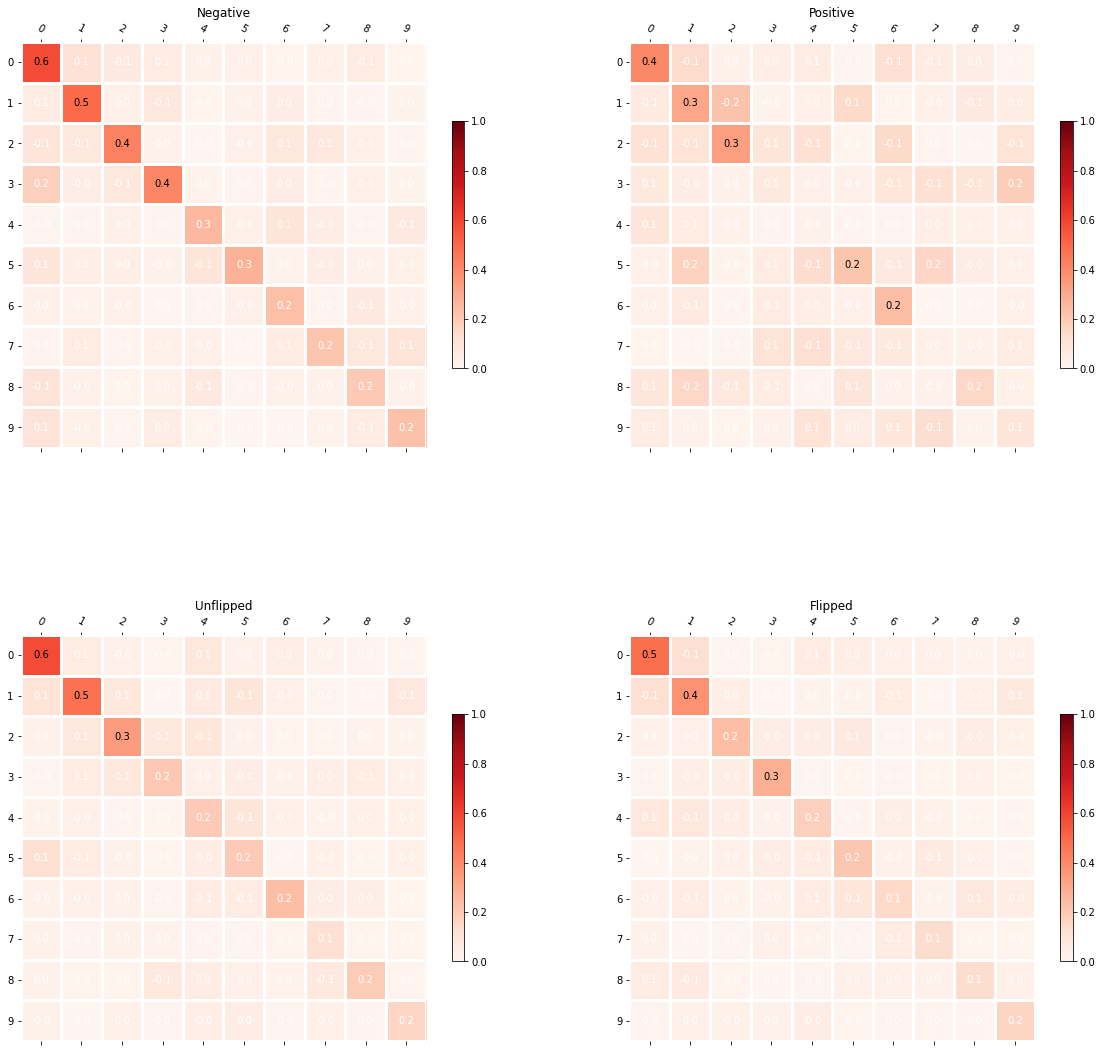

In [12]:
# PCA + PLSCanonical
def calculate_correlations_pcs(expression, methylation):
    coef_res = np.zeros((expression.shape[1], expression.shape[1]))
    for i in range(coef_res.shape[0]):
        for j in range(coef_res.shape[0]):
            p_coef, _ = spearmanr(expression[:, i],
                                methylation[:, j])
            coef_res[i][j] = p_coef
    return coef_res

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    From: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    """
    if not ax:
        ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=True,
                   labeltop=True, labelbottom=False)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")
    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    From: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    """
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)
    return texts

negative_corr = calculate_correlations_pcs(cca_test_negative_expression, cca_test_negative_methylation)
positive_corr = calculate_correlations_pcs(cca_test_positive_expression, cca_test_positive_methylation)
unflipped_corr = calculate_correlations_pcs(cca_test_unflipped_expression, cca_test_unflipped_methylation)
flipped_corr = calculate_correlations_pcs(cca_test_flipped_expression, cca_test_flipped_methylation)

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
# negative
ax1 = axes[0][0]
im, cbar = heatmap(abs(negative_corr[:10, :10]), 
              row_labels = np.arange(10),
              col_labels = np.arange(10),
                  ax=ax1, cbar_kw={'shrink':.5}, vmin=0.0, vmax=1)
im.set_cmap('Reds')
annotate_heatmap(im, data=negative_corr, valfmt="{x:.1f}",
                     textcolors=["white", "black"])
ax1.set_title('Negative')
# positive
ax2 = axes[0][1]
im, cbar = heatmap(abs(positive_corr[:10, :10]), 
              row_labels = np.arange(10),
              col_labels = np.arange(10),
                  ax=ax2, cbar_kw={'shrink':.5}, vmin=0.0, vmax=1)
im.set_cmap('Reds')
annotate_heatmap(im, data=positive_corr, valfmt="{x:.1f}",
                     textcolors=["white", "black"])
ax2.set_title('Positive')
# unflipped
ax3 = axes[1][0]
im, cbar = heatmap(abs(unflipped_corr[:10, :10]), 
              row_labels = np.arange(10),
              col_labels = np.arange(10),
                  ax=ax3, cbar_kw={'shrink':.5}, vmin=0.0, vmax=1)
im.set_cmap('Reds')
annotate_heatmap(im, data=unflipped_corr, valfmt="{x:.1f}",
                     textcolors=["white", "black"])
ax3.set_title('Unflipped')
# flipped
ax4 = axes[1][1]
im, cbar = heatmap(abs(flipped_corr[:10, :10]), 
              row_labels = np.arange(10),
              col_labels = np.arange(10),
                  ax=ax4, cbar_kw={'shrink':.5}, vmin=0.0, vmax=1)
im.set_cmap('Reds')
annotate_heatmap(im, data=flipped_corr, valfmt="{x:.1f}",
                     textcolors=["white", "black"])
ax4.set_title('Flipped')